In [465]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as skm
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.inspection import permutation_importance


### Load Dataset

In [431]:
df = pd.read_csv('D:/Seattle Folder/Spring 2025/Data 5322 Statistical Machine Learning II/PracticalWorksheet02/nhis_2022.csv')
df.head(5)


,YEAR,SERIAL,STRATA,PSU,NHISHID,REGION,PERNUM,NHISPID,HHX,SAMPWEIGHT,...,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,HRSLEEP,CVDSHT
0,2022,1,143,16,0002022H000001,4,1,0002022H00000110,H000001,8018.0,...,2,0,110,3,0,0,3,2,8,1
1,2022,2,106,53,0002022H000003,3,1,0002022H00000310,H000003,10117.0,...,1,0,1,0,0,1,1,1,6,2
2,2022,2,106,53,0002022H000003,3,2,0002022H00000320,H000003,7933.0,...,996,996,996,996,996,996,996,996,0,2
3,2022,3,134,13,0002022H000006,2,1,0002022H00000610,H000006,2681.0,...,1,1,1,0,2,0,1,1,6,2
4,2022,4,106,53,0002022H000007,3,1,0002022H00000710,H000007,10233.0,...,3,30,5,1,0,30,6,2,8,2


Create a Subset of Original Data on the basis of responses recieve from different regions, Sex, Age

In the region feature there are 6 categories, enlisted below. 

01 - Northeast
02 - North Central/Midwest
03 - South
04 - West
08- NO DATA IN ROUND
09 - Unknown

We are selecting 03 (South region response to subset the original dataset)

In [432]:
subset_df = df[df['REGION'] == 3]
subset_df.shape

(12954, 48)

Only Select those responses whose age range is greater than or equal to 18

In [433]:
subset_df = subset_df[subset_df['AGE'] >= 18] # only keep those entries which give useful meaning in the data (997: unknown-refused, 998: unknown-not ascerted, 999: unknown-don't know)
subset_df.shape

(10171, 48)

Only Select Male Responses 

In [434]:
subset_df = subset_df[(subset_df['SEX'].isin([1]))]# only keep those entries which give useful meaning in the data (7: unknown-refused, 8: unknown-not ascerted, 9: unknown-don't know)

subset_df.shape

(4516, 48)

Only keep those entries in the Target features which gives meaningful information

1 means No 

2 means Yes

In [435]:
cols = ['CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV']

# Keep rows where ALL disease indicators are 1 or 2 (no 0s)
subset_df = subset_df[(subset_df[cols].isin([1, 2])).all(axis=1)]
subset_df.shape

(4495, 48)

In [436]:
subset_df = subset_df[~subset_df.isin([996, 997, 998, 999]).any(axis=1)]
subset_df.shape


(3546, 48)


As instruted by the professor to drop features from Survey information (variables 1-12): These variables are ID numbers or sample weights from the survey methodology. we can largely ignore these for this homework, but know that this is not a representative sample for the United States-- weighting is important to make extrapolating claims. 

In [437]:

subset_df = subset_df.drop(subset_df.iloc[:, 0:12], axis=1)
subset_df.shape

(3546, 36)

In [438]:
subset_df.columns

Index(['AGE', 'SEX', 'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT',
       'WEIGHT', 'BMICALC', 'HINOTCOVE', 'CANCEREV', 'CHEARTDIEV',
       'DIABETICEV', 'HEARTATTEV', 'STROKEV', 'ALCANYNO', 'ALCDAYSYR',
       'CIGDAYMO', 'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO',
       'SALADSNO', 'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO',
       'SPORDRMNO', 'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO',
       'HRSLEEP', 'CVDSHT'],
      dtype='object')

In [439]:
#print(subset_df.isnull().sum())

In [440]:
targer_df = subset_df[['CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV']]
new_df = subset_df.drop(columns=['CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV'])

In [441]:
targer_df.head(5)

,CANCEREV,CHEARTDIEV,DIABETICEV,HEARTATTEV,STROKEV
1,1,1,1,1,1
4,1,1,1,1,1
12,2,1,1,1,1
33,2,2,2,1,1
50,1,1,1,1,1


In [442]:
new_df.columns


Index(['AGE', 'SEX', 'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT',
       'WEIGHT', 'BMICALC', 'HINOTCOVE', 'ALCANYNO', 'ALCDAYSYR', 'CIGDAYMO',
       'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO', 'SALADSNO',
       'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO',
       'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO', 'HRSLEEP',
       'CVDSHT'],
      dtype='object')

Question : Can lifestyle, sleep, age, healthy food, sugary drinks, and weight predict diabetes?


### Split the data into training and testing 

In [ ]:
# Select predictors

features = [new_df.columns]
target = 'DIABETICEV'

# Drop missing values
#diabestes_df = subset_df.dropna(subset=features + [target])

# Get all columns except target
X = new_df
y = targer_df[target]

# Check shapes
#print(X.shape, y.shape)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Linear Kernel SVM

In [453]:
from sklearn.svm import SVC
linear_model = SVC(kernel='linear', C=1, class_weight='balanced')
linear_model.fit(X_train_scaled, y_train)

SVC(C=1, class_weight='balanced', kernel='linear')

RBF Kernel SVM

In [454]:
rbf_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced')
rbf_model.fit(X_train_scaled, y_train)


SVC(C=1, class_weight='balanced', gamma=0.1)

Polynomial Kernel SVM

In [455]:
poly_model = SVC(kernel='poly', degree=2, C=1,  class_weight='balanced')
poly_model.fit(X_train_scaled, y_train)


SVC(C=1, class_weight='balanced', degree=2, kernel='poly')

In [456]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 4. Evaluate all models ---
models = {
    'Linear SVM': linear_model,
    'RBF SVM': rbf_model,
    'Polynomial SVM': poly_model
}

for name, model in models.items():
    print(f"====== {name} ======")
    y_pred = model.predict(X_test_scaled)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")


====== Linear SVM ======
Accuracy: 0.6651634723788049
Confusion Matrix:
 [[512 276]
 [ 21  78]]
Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.65      0.78       788
           2       0.22      0.79      0.34        99

    accuracy                           0.67       887
   macro avg       0.59      0.72      0.56       887
weighted avg       0.88      0.67      0.73       887



====== RBF SVM ======
Accuracy: 0.7722660653889515
Confusion Matrix:
 [[635 153]
 [ 49  50]]
Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.81      0.86       788
           2       0.25      0.51      0.33        99

    accuracy                           0.77       887
   macro avg       0.59      0.66      0.60       887
weighted avg       0.85      0.77      0.80       887



====== Polynomial SVM ======
Accuracy: 0.6832018038331454
Confusion Matrix:
 [[552 236]
 [ 45  54]]
Class

### Result Interpretation


Among the three SVM models, the RBF kernel achieved the highest accuracy and provided the best balance between precision and recall for diabetes prediction. The Linear SVM struggled to capture complex relationships, while the Polynomial SVM offered modest improvement but still underperformed compared to RBF. Class imbalance affected all models, with lower precision for diabetic prediction. Overall, RBF SVM was the most effective at handling the nonlinear nature of health behavior features.


### Check Class Imbalance Issue in target feature 

Class distribution:
DIABETICEV
1    3114
2     432
Name: count, dtype: int64


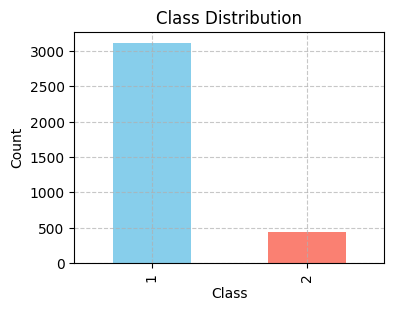


Class proportions:
DIABETICEV
1    0.878173
2    0.121827
Name: proportion, dtype: float64


In [457]:

# 1. Check the class distribution
print("Class distribution:")
print(y.value_counts())

# 2. Plot the distribution for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Calculate imbalance ratio (optional)
imbalance_ratio = y.value_counts(normalize=True)
print("\nClass proportions:")
print(imbalance_ratio)


Severely Imbalanced Dataset ➔ ~87% vs ~12%

Majority Class (Non-Diabetic) ➔ dominates the dataset.

Minority Class (Diabetic) ➔ very underrepresented

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
For linear SVM we got accuracy of around 0.68 ~ 68%. In order to improve accuracy for the linear SVM model. Although, model is classifying everything both classes 1 and 2 but in order to improve the accuracy we needs to have its parameters tuned.  We can search for parameters using GridSearch!

In [458]:
# 1. Define param grid (only C, because kernel is fixed to 'linear')
param_grid = {
    'C': [ 0.1, 1, 5, 10]
}

# 2. Setup GridSearchCV with a linear kernel SVM
linear_svm = SVC(kernel='linear', class_weight='balanced')  # Fix the kernel to 'linear'
grid = GridSearchCV(
    estimator=linear_svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True,
    verbose=3,
    n_jobs=-1

)

# 3. Fit the grid search
grid.fit(X_train, y_train)

# 4. Print best hyperparameter
print(f"Best C: {grid.best_params_}")

# 5. Predict with the best model
best_linear_model = grid.best_estimator_
predictions = best_linear_model.predict(X_test)

# 6. Show classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, predictions))

grid.cv_results_[('mean_test_score')]


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best C: {'C': 5}
Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           1       0.95      0.68      0.79       788
           2       0.22      0.70      0.33        99

    accuracy                           0.68       887
   macro avg       0.58      0.69      0.56       887
weighted avg       0.87      0.68      0.74       887



array([0.67394404, 0.67394404, 0.68146779, 0.67658482])

After hyper parameter tunning of Linear SVM. The accuracy got increased by 1% only from 68% to 69%, not a major difference in accuracy.

For the rbf kernel and polynomial kernel. I have performed hyperparameter tunning using 5 folds for both of the models.

The training for both of the model was taking a lot of time becuase it required to model more than 50 models to trained.

In [471]:


# 1. Define param grid (now tuning both C and gamma for RBF)
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],           # Regularization strength
    'gamma': [0.001, 0.01, 0.1, 1]   # Gamma controls shape of decision boundary
}

# 2. Setup GridSearchCV with RBF kernel SVM
rbf_svm = SVC(kernel='rbf', class_weight='balanced')  # Fix kernel to 'rbf'

grid = GridSearchCV(
    estimator=rbf_svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True,
    verbose=3,
    n_jobs=-1
)

# 3. Fit the grid search
grid.fit(X_train, y_train)

# 4. Print best hyperparameters
print(f"Best Parameters: {grid.best_params_}")

# 5. Predict with the best model
best_rbf_model = grid.best_estimator_
predictions = best_rbf_model.predict(X_test)

# 6. Show classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, predictions))

# 7. Optionally show mean cross-validation scores
grid.cv_results_[('mean_test_score')]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'gamma': 0.1}
Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           1       0.89      1.00      0.94       788
           2       0.00      0.00      0.00        99

    accuracy                           0.89       887
   macro avg       0.44      0.50      0.47       887
weighted avg       0.79      0.89      0.84       887



c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

array([0.27551718, 0.1252347 , 0.1252347 , 0.1252347 , 0.85144429,
       0.42589312, 0.42589312, 0.42589312, 0.82173584, 0.87326084,
       0.8747653 , 0.8747653 , 0.83301474, 0.87363678, 0.8747653 ,
       0.8747653 , 0.83452062, 0.87363678, 0.8747653 , 0.8747653 ])

RBF kernel using gridsearch hyperparameter tuning improves the accuracy to 89% but model is only classifying the "No" class of deiabetes.

In [472]:

# 1. Define param grid (tuning C and degree for polynomial)
param_grid = {
    'C': [0.1, 1, 5, 10],           # Regularization parameter
    'degree': [2, 3, 4]              # Degree of polynomial kernel
}

# 2. Setup GridSearchCV with polynomial kernel SVM
poly_svm = SVC(kernel='poly', class_weight='balanced')  # Fix kernel to 'poly'

grid = GridSearchCV(
    estimator=poly_svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True,
    verbose=3,
    n_jobs=-1
)

# 3. Fit the grid search
grid.fit(X_train, y_train)

# 4. Print best hyperparameters
print(f"Best Parameters: {grid.best_params_}")

# 5. Predict with the best model
best_poly_model = grid.best_estimator_
predictions = best_poly_model.predict(X_test)

# 6. Show classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, predictions))

# 7. Optionally, view cross-validation scores
grid.cv_results_[('mean_test_score')]

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 5, 'degree': 3}
Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           1       0.95      0.66      0.78       788
           2       0.21      0.73      0.33        99

    accuracy                           0.66       887
   macro avg       0.58      0.69      0.55       887
weighted avg       0.87      0.66      0.73       887



array([0.5810423 , 0.54192756, 0.50356187, 0.67431219, 0.66378446,
       0.64121816, 0.67958385, 0.68296731, 0.67845532, 0.68259137,
       0.68296589, 0.68259137])

For polynomial kernel the hyperparameter tuning for this model downgraded the accuracy from 68% to 66% with c = 5 and degree = 3. But Good thing is model is classifying the "Yes" class for diabetes with improved (precision, recall, F1-Score). 

Top 5 Important Features for (Linear, RBF, Polynomial)

In [469]:
# Get feature names (assuming you have them stored in 'X.columns')
feature_names = X.columns

# Get coefficients
linear_coefs = best_linear_model.coef_[0]

# Create a DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(linear_coefs)
})

# Get Top 5 features
top5_linear = coef_df.sort_values(by='importance', ascending=False).head(5)
print(top5_linear)

      feature  importance
9   HINOTCOVE    1.775581
8     BMICALC    1.206375
6      HEIGHT    0.662853
28    PIZZANO    0.544359
24  SPORDRMNO    0.342594


Get Top 5 Predictors for RBF (Using Permutation Importance)

In [466]:

# RBF SVM Permutation Importance
print("Top 5 Features for RBF Model")
perm_rbf = permutation_importance(best_rbf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

perm_rbf_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(perm_rbf.importances_mean)
})
top5_rbf = perm_rbf_df.sort_values(by='importance', ascending=False).head(5)
print(top5_rbf)


Top 5 Features for RBF Model


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, 

     feature  importance
0        AGE         0.0
16    VEGENO         0.0
29   HRSLEEP         0.0
28   PIZZANO         0.0
27  POTATONO         0.0


In [ ]:
# Assuming X was properly defined from the beginning
feature_names = X.columns.tolist()  

# Then run permutation importance as you did
perm_poly = permutation_importance(best_poly_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Now safe to continue
perm_poly_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(perm_poly.importances_mean)
})

# Sort and pick top 5
top5_poly = perm_poly_df.sort_values(by='importance', ascending=False).head(5)
print(top5_poly)


       feature  importance
32     PIZZANO    0.032175
19      FRUTNO    0.032017
11  CHEARTDIEV    0.027161
15   ALCDAYSYR    0.016542
6       HEIGHT    0.015555


SVM Decision Boundary for Linear Kernel

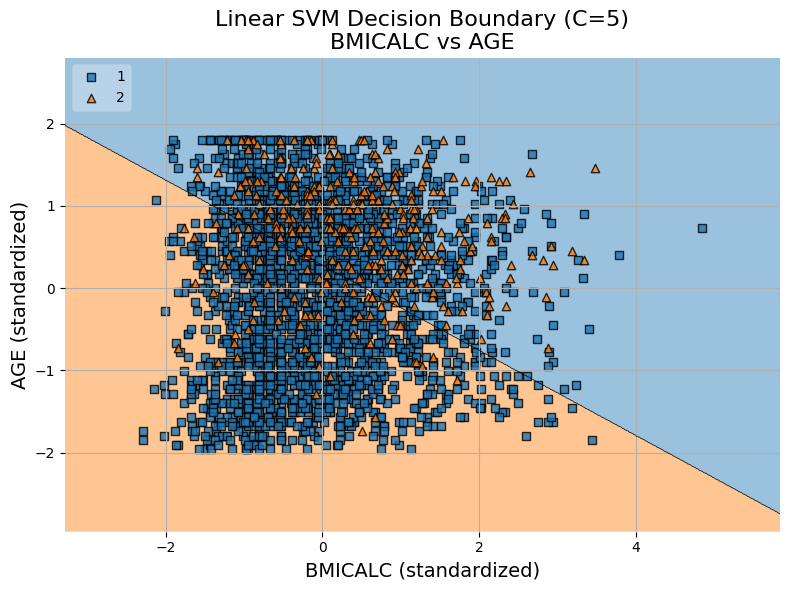

In [496]:
# Example: Manually choose known continuous features
feature_x = 'BMICALC'  # Body Mass Index
feature_y = 'AGE'      # Age

X_plot = X_train[[feature_x, feature_y]]
y_plot = y_train

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

# Train with best C from previous GridSearch
svm_vis = SVC(kernel='linear', C=grid.best_params_['C'], class_weight='balanced')
svm_vis.fit(X_scaled, y_plot)

# Plot
plt.figure(figsize=(8, 6))
plot_decision_regions(X_scaled, y_plot.to_numpy().astype(int), clf=svm_vis, legend=2)

plt.xlabel(f'{feature_x} (standardized)', fontsize=14)
plt.ylabel(f'{feature_y} (standardized)', fontsize=14)
plt.title(f'Linear SVM Decision Boundary (C={grid.best_params_["C"]})\n{feature_x} vs {feature_y}', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()


SVM Boundary for RBF Kernel

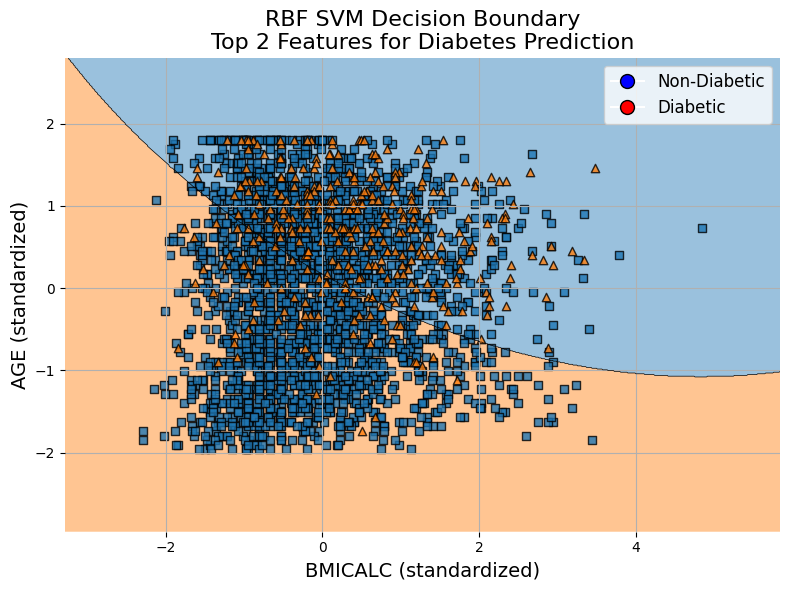

In [499]:

# 1. Choose 2 good continuous features
feature_x = 'BMICALC'
feature_y = 'AGE'
X_plot = X_train[[feature_x, feature_y]]
y_plot = y_train

# 2. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

# 3. Define and train RBF SVM model
rbf_svm = SVC(kernel='rbf', C=1, gamma=0.01, class_weight='balanced')
rbf_svm.fit(X_scaled, y_plot)

# 4. Plot the decision boundary
plt.figure(figsize=(8,6))
plot_decision_regions(X_scaled, y_plot.to_numpy().astype(int), clf=rbf_svm, legend=2)

plt.xlabel(f'{feature_x} (standardized)', fontsize=14)
plt.ylabel(f'{feature_y} (standardized)', fontsize=14)
plt.title('RBF SVM Decision Boundary\nTop 2 Features for Diabetes Prediction', fontsize=16)
plt.grid(True)

# Custom Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Diabetic',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Diabetic',
           markerfacecolor='red', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

SVM  Decision Boundary for Polynomial Kernel

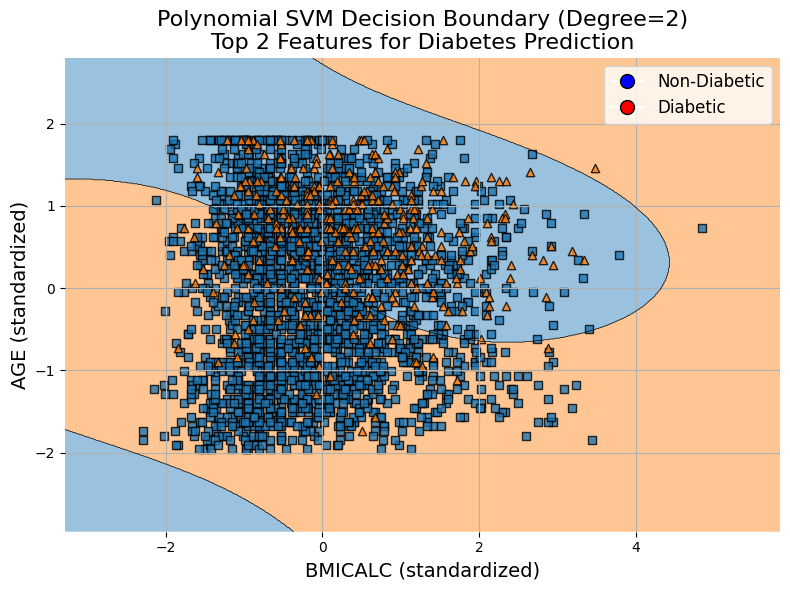

In [ ]:
# 1. Choose same 2 features
feature_x = 'BMICALC'
feature_y = 'AGE'
X_plot = X_train[[feature_x, feature_y]]
y_plot = y_train

# 2. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

# 3. Define and train Polynomial SVM model
poly_svm = SVC(kernel='poly', degree=3, C=5, coef0=1, class_weight='balanced')  
poly_svm.fit(X_scaled, y_plot)

# 4. Plot
plt.figure(figsize=(8,6))
plot_decision_regions(X_scaled, y_plot.to_numpy().astype(int), clf=poly_svm, legend=2)

plt.xlabel(f'{feature_x} (standardized)', fontsize=14)
plt.ylabel(f'{feature_y} (standardized)', fontsize=14)
plt.title('Polynomial SVM Decision Boundary (Degree=3)\nTop 2 Features for Diabetes Prediction', fontsize=16)
plt.grid(True)

# Custom Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Diabetic',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Diabetic',
           markerfacecolor='red', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


### SVM Decision Boundaries for (Linear, RBF, Polynomial) Analysis

Linear SVM Decision Boundary 

This SVM decision boundary plot shows how the linear kernel separates diabetic and non-diabetic individuals based on standardized BMI and age.
The boundary suggests that individuals with higher BMI and younger age are more likely to be classified as diabetic.
However, there is significant class overlap, indicating that BMI and age alone may not provide strong separation for diabetes prediction.


RBF SVM Decision Boundary

This RBF SVM decision boundary plot captures more complex, nonlinear patterns between BMI, age, and diabetes status.
The curved boundary adapts to clusters better than the linear model, but class overlap remains significant.
It shows that while BMI and age carry some predictive power, they may not be sufficient alone to clearly separate diabetic from non-diabetic individuals.

Polynomial SVM Decision Boundary

This Polynomial SVM decision boundary (degree=2) demonstrates a more flexible, curved separation between diabetic and non-diabetic groups using BMI and age.
The wavy boundary indicates interactions between the two variables, but it still struggles with overlapping regions.
This suggests that while a polynomial kernel captures more complexity than a linear one, additional features may be needed to improve classification.







